<font color = blue><font size = 6> 실험설명 </font></font><br>
Seasonality 한주기를 임의 설정한후 moving average를 주기마다 겹치지 않게 해보겠다(Stride를 조정하겠다는 의미)<br>
여기서는 Linear layer하나에 한개의 trend가 들어가게 된다<br>
이것을 하는 이유는 DLinear에서 Decompose를 할때 moving average 자체에 어느정도의 seasonallity가 포함돼 있는거 같기 때문에 이를 더 엄격하게 구분하기 위해서 이다 
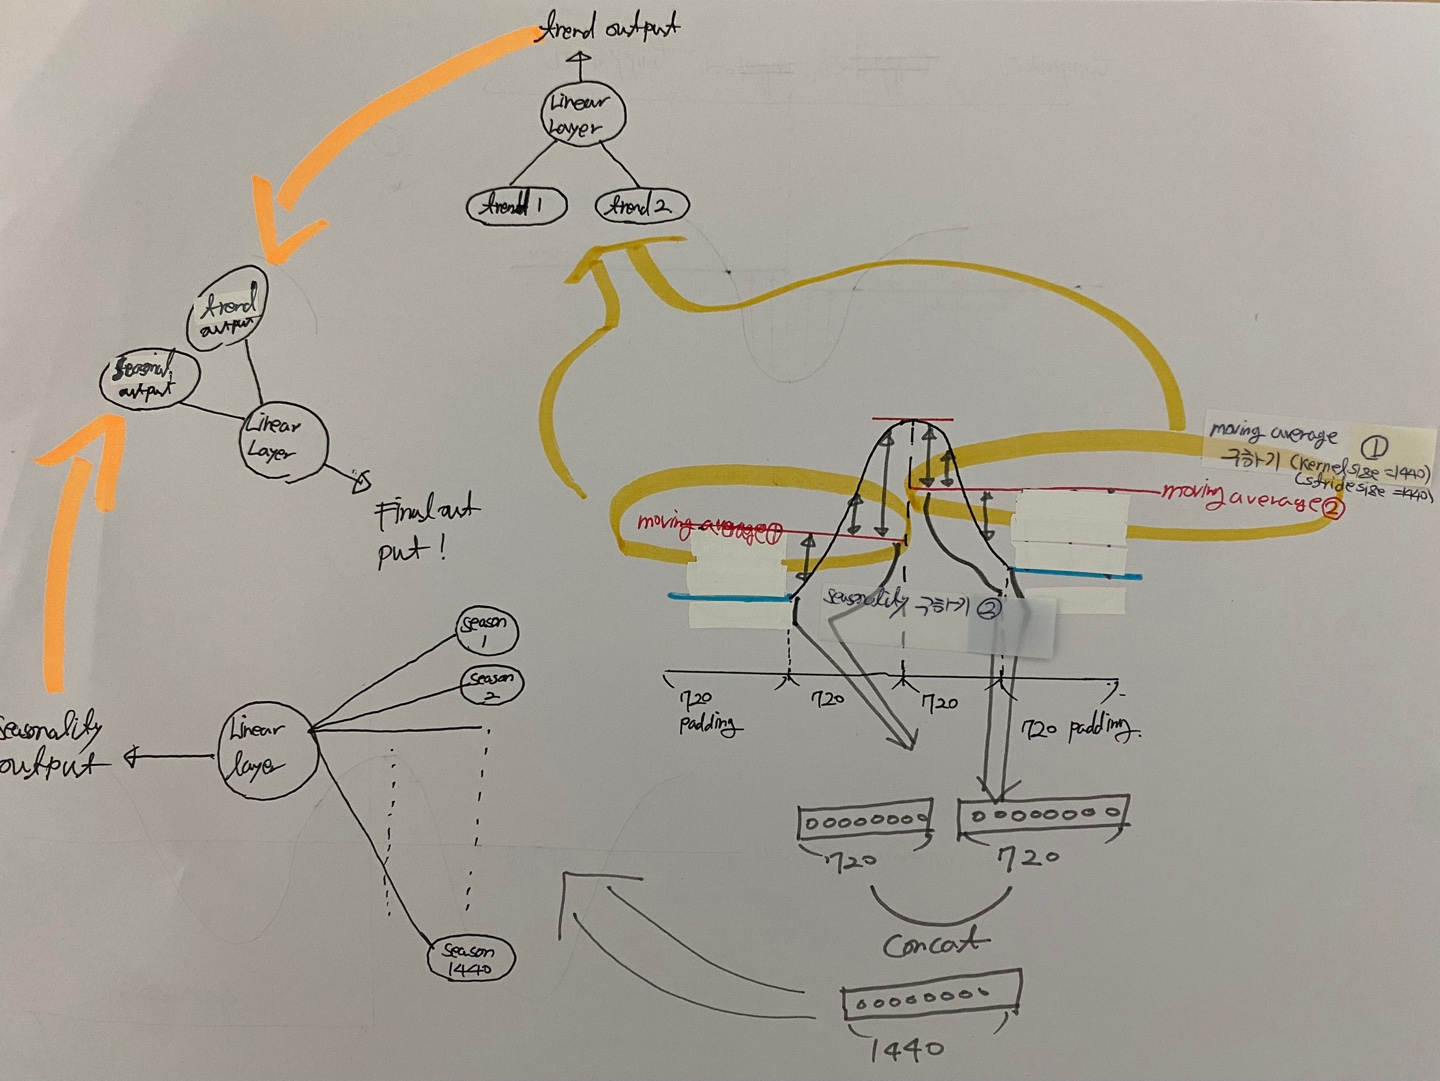

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [30]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,MAPE,RMSE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/2.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,4.011808
1,4.016080
2,3.993376
3,3.981656
4,3.996736
...,...
38875,7.981184
38876,7.982088
38877,7.980072
38878,7.974312


<AxesSubplot: >

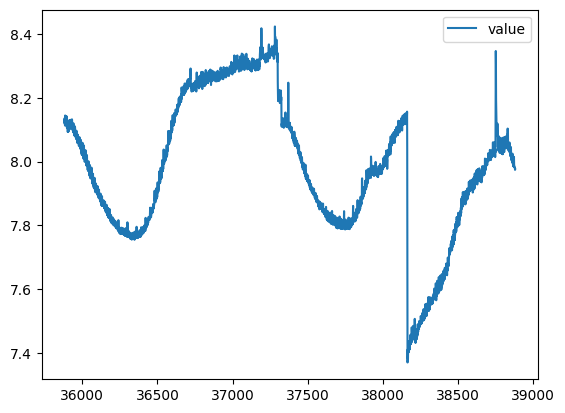

In [4]:
data[-3000:].plot() # 1일의 계절성이 있는것으로 판단된다

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel2/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))
        
        
        return x

[1,1,1] Size에서 [1,2,1] Size를 빼면 앞에꺼 원소 한개를 뒤에 원소 2개에 대응한다

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size,stride):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size=kernel_size,stride=stride)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        
        moving_mean = moving_mean.permute(0,2,1)
        
        x = x.permute(0,2,1)
        
        res = torch.cat([x[:,:720,:] - moving_mean[:,0:1,:],x[:,720:,:]-moving_mean[:,1:2,:]],dim=1)
        
        # Classical ma중에서 additive model
        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 1440
        self.stride = 1440
        self.decomposition = series_decomp(kernel_size,self.stride)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len//self.stride,self.pred_len)) # 이렇게 설정하면 현재 상황에선 Layer당 Unit이 1개
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(2,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x/div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.permute(0,2,1).to(self.device)
        
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_579436/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.99 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-04.


In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.9000e-05.
smape 132.0235224216305 %
Adjusting learning rate of group 0 to 9.8010e-05.
smape 82.15906765377312 %
Adjusting learning rate of group 0 to 9.7030e-05.
smape 49.20884895917268 %
Adjusting learning rate of group 0 to 9.6060e-05.
smape 21.841012713164417 %
Adjusting learning rate of group 0 to 9.5099e-05.
smape 3.1132048938412504 %
Adjusting learning rate of group 0 to 9.4148e-05.
smape 0.9068033718013843 %
Adjusting learning rate of group 0 to 9.3207e-05.
smape 0.9078853822596458 %
Adjusting learning rate of group 0 to 9.2274e-05.
smape 0.8840623977035827 %
Adjusting learning rate of group 0 to 9.1352e-05.
smape 0.8496706065386861 %
Adjusting learning rate of group 0 to 9.0438e-05.
smape 0.8960461596024294 %
Adjusting learning rate of group 0 to 8.9534e-05.
smape 0.8000929467380047 %
Adjusting learning rate of group 0 to 8.8638e-05.
smape 0.8724252639504487 %
Adjusting learning rate of group 0 to 8.7752e-05.
smape 0.7915459473941431 %
Ad

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.04931917747217085 %
SMAPE 0.041491176114334394 %
SMAPE 0.04993790807446885 %
SMAPE 0.17235650685040582 %
SMAPE 0.010902664950506846 %
SMAPE 0.015469741796920289 %
SMAPE 0.09919332675258374 %
SMAPE 0.018295564942832243 %
SMAPE 0.010102491131874558 %
SMAPE 0.027511119868051992 %
SMAPE 0.003568832402280009 %
SMAPE 0.014723985092231828 %
SMAPE 0.02131654366399971 %
SMAPE 0.050706672977867136 %
SMAPE 0.049653175955427294 %
SMAPE 0.03148764227535139 %
SMAPE 0.062315747968227704 %
SMAPE 0.003320337760669645 %
SMAPE 0.004080605333200538 %
SMAPE 0.006830292554695915 %
SMAPE 0.013556115421692994 %
SMAPE 0.03334548533462112 %
SMAPE 0.017424989218170595 %
SMAPE 0.07503762462965824 %
SMAPE 0.032830560593708924 %
SMAPE 0.02369611617032774 %
SMAPE 0.04084701565091109 %
SMAPE 0.026567372556542068 %
SMAPE 0.04563025572804236 %
SMAPE 0.03371038548516481 %
SMAPE 0.04442546040395712 %
SMAPE 0.05741871755583361 %
SMAPE 0.09052605716351536 %
SMAPE 0.008418163747251128 %
SMAPE 0.005648522890965069 %


SMAPE 0.004669831900287136 %
SMAPE 0.011708851690855226 %
SMAPE 0.028243126298548304 %
SMAPE 0.0164839652018145 %
SMAPE 0.017661272935583838 %
SMAPE 0.008593853329074364 %
SMAPE 0.005324619761779559 %
SMAPE 0.01461561054276217 %
SMAPE 0.009946024133114406 %
SMAPE 0.009563412497584522 %
SMAPE 0.019915534861866035 %
SMAPE 0.013047915601418936 %
SMAPE 0.11029686028655304 %
SMAPE 0.05612071443692913 %
SMAPE 0.009546249397935469 %
SMAPE 0.003688934927026821 %
SMAPE 0.010939212267373932 %
SMAPE 0.0032401980182612537 %
SMAPE 0.01400968880579967 %
SMAPE 0.006347137336888409 %
SMAPE 0.01281636305691336 %
SMAPE 0.004664623811123647 %
SMAPE 0.018035587064048286 %
SMAPE 0.02857017185306177 %
SMAPE 0.02518994086767634 %
SMAPE 0.014041677551460907 %
SMAPE 0.006522595453589019 %
SMAPE 0.017334835682014216 %
SMAPE 0.008419066695246613 %
SMAPE 0.013137851039410009 %
SMAPE 0.020836437410139297 %
SMAPE 0.011299951041792156 %
SMAPE 0.01502138540240594 %
SMAPE 0.021466130959936436 %
SMAPE 0.026474015045664

SMAPE 0.04783306718172753 %
SMAPE 0.03647361623603729 %
SMAPE 0.0478544307248967 %
SMAPE 0.06001209748831115 %
SMAPE 0.07488147986822469 %
SMAPE 0.005022406423677239 %
SMAPE 0.02379323087990315 %
SMAPE 0.044647816696681275 %
SMAPE 0.017574707851736093 %
SMAPE 0.036046903747774195 %
SMAPE 0.036662626563838785 %
SMAPE 0.02885759021182821 %
SMAPE 0.033095866896616144 %
SMAPE 0.03957230094692932 %
SMAPE 0.03472476423758053 %
SMAPE 0.02008997846883176 %
SMAPE 0.005455320408827902 %
SMAPE 0.0688696420675825 %
SMAPE 0.034156573944841284 %
SMAPE 0.04094974723750511 %
SMAPE 0.055083061799450654 %
SMAPE 0.05146317034405002 %
SMAPE 0.059642310914966856 %
SMAPE 0.06374016575000496 %
SMAPE 0.0902197280645396 %
SMAPE 0.0069542652904175375 %
SMAPE 0.01597306291694167 %
SMAPE 0.05601431714271143 %
SMAPE 0.019498282845574977 %
SMAPE 0.00958353089282582 %
SMAPE 0.008958183310014078 %
SMAPE 0.037076437226915004 %
SMAPE 0.016862733758195247 %
SMAPE 0.0067507056774474 %
SMAPE 0.040888830190169756 %
SMAPE 0

SMAPE 0.006198171217590698 %
SMAPE 0.033632158961495406 %
SMAPE 0.021789057232354025 %
SMAPE 0.015323941515362092 %
SMAPE 0.00673658257187526 %
SMAPE 0.024487592343518827 %
SMAPE 0.028247680855997714 %
SMAPE 0.015316240310312423 %
SMAPE 0.05939733392290236 %
SMAPE 0.04265843775689859 %
SMAPE 0.018932100217028847 %
SMAPE 0.01897191185878455 %
SMAPE 0.018756378287434927 %
SMAPE 0.04567486312288338 %
SMAPE 0.024034164717107842 %
SMAPE 0.01274845401951552 %
SMAPE 0.031129058462624926 %
SMAPE 0.01989570601027424 %
SMAPE 0.051807948357634366 %
SMAPE 0.04999036412345958 %
SMAPE 0.03000798977114982 %
SMAPE 0.05744595686712728 %
SMAPE 0.03510008000699827 %
SMAPE 0.06130703253694491 %
SMAPE 0.09555146400907688 %
SMAPE 0.13433819886586207 %
SMAPE 0.08908951007987298 %
SMAPE 0.010060788880764449 %
SMAPE 0.023151361014015492 %
SMAPE 0.011298138837268823 %
SMAPE 0.01447880240698396 %
SMAPE 0.01781471002419721 %
SMAPE 0.03272611449096985 %
SMAPE 0.0037852586967801476 %
SMAPE 0.011306273364425579 %
SM

SMAPE 0.052310791495727926 %
SMAPE 0.0224599187313288 %
SMAPE 0.0077199638453748776 %
SMAPE 0.02920964657482727 %
SMAPE 0.020708555377950688 %
SMAPE 0.04077353064712952 %
SMAPE 0.027508472553847692 %
SMAPE 0.04871873595766374 %
SMAPE 0.026812809867720944 %
SMAPE 0.009374510876341446 %
SMAPE 0.05988220228186947 %
SMAPE 0.011117311441239508 %
SMAPE 0.006906192958922475 %
SMAPE 0.05943411672714661 %
SMAPE 0.0115562648369405 %
SMAPE 0.009046268450561001 %
SMAPE 0.043504319257863244 %
SMAPE 0.021465886772723763 %
SMAPE 0.009205092512388546 %
SMAPE 0.027014329681719573 %
SMAPE 0.08631826076327798 %
SMAPE 0.002782037132391224 %
SMAPE 0.019735886135435976 %
SMAPE 0.059797561606046656 %
SMAPE 0.006491702434743729 %
SMAPE 0.022419343339151965 %
SMAPE 0.024413365892314687 %
SMAPE 0.011193544378244269 %
SMAPE 0.009572418358516188 %
SMAPE 0.027140482047002482 %
SMAPE 0.0454863379662811 %
SMAPE 0.0056219241761255034 %
SMAPE 0.01218939097668681 %
SMAPE 0.006180169313125816 %
SMAPE 0.01256272088858168

SMAPE 0.0050792240432429026 %
SMAPE 0.025431277866431398 %
SMAPE 0.0077080097257749 %
SMAPE 0.004743992212183912 %
SMAPE 0.07579358930070157 %
SMAPE 0.0146005901577837 %
SMAPE 0.013369093079063532 %
SMAPE 0.042449718471743836 %
SMAPE 0.024941893379036628 %
SMAPE 0.03740232655655973 %
SMAPE 0.007783223088154045 %
SMAPE 0.029303369905449017 %
SMAPE 0.04456377937706435 %
SMAPE 0.018167872704793808 %
SMAPE 0.06184442771086651 %
SMAPE 0.014861564154671212 %
SMAPE 0.012644422321955062 %
SMAPE 0.01633679186211623 %
SMAPE 0.007036841543879291 %
SMAPE 0.0236804747663939 %
SMAPE 0.004541167601843199 %
SMAPE 0.01953706713160841 %
SMAPE 0.009069682423955783 %
SMAPE 0.03182312656841191 %
SMAPE 0.0599333236154962 %
SMAPE 0.005319902596411907 %
SMAPE 0.00430535748910188 %
SMAPE 0.030078165548587776 %
SMAPE 0.008007740215134618 %
SMAPE 0.02479311382840166 %
SMAPE 0.003620470279201982 %
SMAPE 0.02579666139126857 %
SMAPE 0.00562605158313545 %
SMAPE 0.023986982324061046 %
SMAPE 0.053839635520262163 %
SMA

SMAPE 0.0130357309625424 %
SMAPE 0.028106804865899445 %
SMAPE 0.007596206562112683 %
SMAPE 0.015799655423933245 %
SMAPE 0.022385259004522595 %
SMAPE 0.027558221649101707 %
SMAPE 0.02558839331686613 %
SMAPE 0.03132439255000463 %
SMAPE 0.05065424769213678 %
SMAPE 0.01012311083132289 %
SMAPE 0.028718960289552342 %
SMAPE 0.025840478836300914 %
SMAPE 0.009239323855126713 %
SMAPE 0.017377201440780254 %
SMAPE 0.01205035005824584 %
SMAPE 0.033160599636232746 %
SMAPE 0.012067411781572446 %
SMAPE 0.011174149186331306 %
SMAPE 0.0452504291384912 %
SMAPE 0.016164866848214388 %
SMAPE 0.009832153393062981 %
SMAPE 0.0313816674025702 %
SMAPE 0.024780944283953943 %
SMAPE 0.03731048556528549 %
SMAPE 0.0239723080294425 %
SMAPE 0.025139421314094076 %
SMAPE 0.01528445246784571 %
SMAPE 0.028026013594399043 %
SMAPE 0.05158267178022413 %
SMAPE 0.007779632500273692 %
SMAPE 0.013594916975591785 %
SMAPE 0.028173515650451005 %
SMAPE 0.018579813179940174 %
SMAPE 0.019503322394484712 %
SMAPE 0.013620301966483339 %
S

SMAPE 0.0028042973031574547 %
SMAPE 0.004188597708889574 %
SMAPE 0.0066456317299525836 %
SMAPE 0.05199976341350521 %
SMAPE 0.004661947810859601 %
SMAPE 0.015120598707142108 %
SMAPE 0.012691405661684032 %
SMAPE 0.013190255796040164 %
SMAPE 0.0039788223404571 %
SMAPE 0.0050888562724651365 %
SMAPE 0.013582687147319916 %
SMAPE 0.010603832286506076 %
SMAPE 0.008358815257679453 %
SMAPE 0.022582235600793865 %
SMAPE 0.023490954985021517 %
SMAPE 0.026451006420842305 %
SMAPE 0.013939350750774793 %
SMAPE 0.01735989938424609 %
SMAPE 0.028134207583320858 %
SMAPE 0.030309226540538248 %
SMAPE 0.02029096225533067 %
SMAPE 0.007745158425393584 %
SMAPE 0.004211415616907743 %
SMAPE 0.07363182760911968 %
SMAPE 0.004170271308396423 %
SMAPE 0.0019807311682598083 %
SMAPE 0.003348037576728302 %
SMAPE 0.014825162465228914 %
SMAPE 0.0034914176268188153 %
SMAPE 0.004570777433698936 %
SMAPE 0.017033157145931455 %
SMAPE 0.011485964896422729 %
SMAPE 0.018089050477158253 %
SMAPE 0.026447796311003913 %
SMAPE 0.0076644

SMAPE 0.012638633862650295 %
SMAPE 0.005558723584726977 %
SMAPE 0.012287612335853737 %
SMAPE 0.016587570866249735 %
SMAPE 0.020306189688938048 %
SMAPE 0.04781598692972011 %
SMAPE 0.036293102010859 %
SMAPE 0.023102249855725177 %
SMAPE 0.07476538478128703 %
SMAPE 0.022525092457556184 %
SMAPE 0.024884557008135744 %
SMAPE 0.04377842574172064 %
SMAPE 0.02691037288634846 %
SMAPE 0.04157368976774478 %
SMAPE 0.029667861678262852 %
SMAPE 0.03065252378227967 %
SMAPE 0.031147137167863548 %
SMAPE 0.03359841604718383 %
SMAPE 0.08140394830508058 %
SMAPE 0.05625867775381721 %
SMAPE 0.07037697434725487 %
SMAPE 0.04760214833572718 %
SMAPE 0.028680379568982065 %
SMAPE 0.03485461018611602 %
SMAPE 0.014244632193253894 %
SMAPE 0.022455869612343804 %
SMAPE 0.026582808139608005 %
SMAPE 0.021711767939905258 %
SMAPE 0.07735920214577163 %
SMAPE 0.03225491068531028 %
SMAPE 0.024998676335144413 %
SMAPE 0.034597610240325594 %
SMAPE 0.033702807301494886 %
SMAPE 0.05195964621907478 %
SMAPE 0.03920220577066402 %
SMAP

SMAPE 0.1277758973330947 %
SMAPE 0.09415254302297171 %
SMAPE 0.06027289718622342 %
SMAPE 0.1582358691571244 %
SMAPE 0.08443270433872385 %
SMAPE 0.0646674899107893 %
SMAPE 0.030022494758668472 %
SMAPE 0.10373323232397524 %
SMAPE 0.03214385026490163 %
SMAPE 0.1330741916099214 %
SMAPE 0.10870301409522654 %
SMAPE 0.04513688304814423 %
SMAPE 0.043995067419018596 %
SMAPE 0.17378036463924218 %
SMAPE 0.04142725266228808 %
SMAPE 0.0872555367386667 %
SMAPE 0.1763106976668496 %
SMAPE 0.1402501477032274 %
SMAPE 0.03270927246126121 %
SMAPE 0.0820177396726649 %
SMAPE 0.1278402743347442 %
SMAPE 0.02580212511226421 %
SMAPE 0.07835127683546261 %
SMAPE 0.04518446602253334 %
SMAPE 0.028963359333602057 %
SMAPE 0.07839782094379188 %
SMAPE 0.02001074297314176 %
SMAPE 0.10220768324143137 %
SMAPE 0.030199415639799554 %
SMAPE 0.061015273510520274 %
SMAPE 0.10760948816096061 %
SMAPE 0.11440608866678305 %
SMAPE 0.0720108208226975 %
SMAPE 0.03553362682842476 %
SMAPE 0.12877620034123538 %
SMAPE 0.08325713047815952

SMAPE 0.009404726945660968 %
SMAPE 0.04952249979487533 %
SMAPE 0.028467698007261788 %
SMAPE 0.05126144836071944 %
SMAPE 0.01649195443519602 %
SMAPE 0.05328472507288495 %
SMAPE 0.026512101117987186 %
SMAPE 0.06557426016115642 %
SMAPE 0.06223162482848466 %
SMAPE 0.08553679218857724 %
SMAPE 0.039898861710526035 %
SMAPE 0.05094207147612905 %
SMAPE 0.04023092985585208 %
SMAPE 0.08837988919344753 %
SMAPE 0.029662771240737133 %
SMAPE 0.03611040017483447 %
SMAPE 0.041341368801568024 %
SMAPE 0.021811910031715342 %
SMAPE 0.07019012233854482 %
SMAPE 0.07975151636173905 %
SMAPE 0.08169037786865374 %
SMAPE 0.04450216029681542 %
SMAPE 0.033623991940658016 %
SMAPE 0.06874810489352967 %
SMAPE 0.015827156234081485 %
SMAPE 0.11386969391969616 %
SMAPE 0.051346953271604434 %
SMAPE 0.0459969277640937 %
SMAPE 0.07692088376961692 %
SMAPE 0.08150538767444004 %
SMAPE 0.017613808946407516 %
SMAPE 0.08414140824424976 %
SMAPE 0.01746105418541788 %
SMAPE 0.02280002272823367 %
SMAPE 0.04161649835714343 %
SMAPE 0.07

SMAPE 0.04129492801791912 %
SMAPE 0.02464589123485439 %
SMAPE 0.02016320549375905 %
SMAPE 0.014839037271684674 %
SMAPE 0.0310846219567793 %
SMAPE 0.023121089118262717 %
SMAPE 0.04536352763992113 %
SMAPE 0.016644903851101844 %
SMAPE 0.011166426973574062 %
SMAPE 0.022504188225866528 %
SMAPE 0.03293350769445169 %
SMAPE 0.035802868396103804 %
SMAPE 0.018727717698311608 %
SMAPE 0.017625572165798076 %
SMAPE 0.011976658664480055 %
SMAPE 0.02458496508643293 %
SMAPE 0.02434750827296739 %
SMAPE 0.03999392749528852 %
SMAPE 0.02009133447265299 %
SMAPE 0.09091280971290416 %
SMAPE 0.01897776461282774 %
SMAPE 0.01267973301537495 %
SMAPE 0.024731231317218768 %
SMAPE 0.011277936590353477 %
SMAPE 0.013101896885814313 %
SMAPE 0.03170427436543832 %
SMAPE 0.05272423944222737 %
SMAPE 0.02310703493753863 %
SMAPE 0.03300209913595609 %
SMAPE 0.03165468169336805 %
SMAPE 0.012206680489356359 %
SMAPE 0.005473179601040101 %
SMAPE 0.008580992958513889 %
SMAPE 0.027954446279068183 %
SMAPE 0.024805880383212298 %
SMAP

SMAPE 0.010819589838803267 %
SMAPE 0.019758963077947556 %
SMAPE 0.021259483663584433 %
SMAPE 0.015841367939167128 %
SMAPE 0.018496230106165967 %
SMAPE 0.02468682666665245 %
SMAPE 0.052026161450669406 %
SMAPE 0.0171105109382097 %
SMAPE 0.029188124647589575 %
SMAPE 0.024802937246278134 %
SMAPE 0.02141083391234133 %
SMAPE 0.03541072054247252 %
SMAPE 0.027703358327158867 %
SMAPE 0.019288870221828347 %
SMAPE 0.02527587422832767 %
SMAPE 0.015088639596797293 %
SMAPE 0.03035735944121143 %
SMAPE 0.017693095713184448 %
SMAPE 0.05202997389824305 %
SMAPE 0.07021351393655095 %
SMAPE 0.06106299304121876 %
SMAPE 0.05467582998994658 %
SMAPE 0.05448672035572599 %
SMAPE 0.0499868763199629 %
SMAPE 0.03311690954259916 %
SMAPE 0.022688290071528172 %
SMAPE 0.03754521069828343 %
SMAPE 0.02701852328118548 %
SMAPE 0.05938256698857458 %
SMAPE 0.049766640220468616 %
SMAPE 0.02135079306924581 %
SMAPE 0.06883141559484329 %
SMAPE 0.0530246108147594 %
SMAPE 0.008807323909707065 %
SMAPE 0.03313982079964717 %
SMAPE 0.

SMAPE 0.0678538445695267 %
SMAPE 0.017591246615666023 %
SMAPE 0.016136328703851177 %
SMAPE 0.09154061097387967 %
SMAPE 0.025051065417414975 %
SMAPE 0.016019755663819524 %
SMAPE 0.05377918408532877 %
SMAPE 0.0600643302814774 %
SMAPE 0.03737099321176629 %
SMAPE 0.051800866828898506 %
SMAPE 0.02293533179431506 %
SMAPE 0.0861118778002492 %
SMAPE 0.030997172294519263 %
SMAPE 0.024644642769970915 %
SMAPE 0.036376705136717646 %
SMAPE 0.016711605629097903 %
SMAPE 0.016559339424475183 %
SMAPE 0.016790875909464376 %
SMAPE 0.03691503624338566 %
SMAPE 0.09888873369800422 %
SMAPE 0.04258581002568462 %
SMAPE 0.04111299402939039 %
SMAPE 0.04135316121789856 %
SMAPE 0.008554204023909051 %
SMAPE 0.04142319489676538 %
SMAPE 0.029419348913506838 %
SMAPE 0.015293154972823686 %
SMAPE 0.07786057060923213 %
SMAPE 0.0615925239869739 %
SMAPE 0.10486745177058765 %
SMAPE 0.029431655970256543 %
SMAPE 0.0379933962327641 %
SMAPE 0.05439246965948996 %
SMAPE 0.03428076003183378 %
SMAPE 0.030068024022057216 %
SMAPE 0.0

SMAPE 0.1812489512873725 %
SMAPE 0.0468912344855994 %
SMAPE 0.021923278150097758 %
SMAPE 0.006252929874648317 %
SMAPE 0.011686722345530143 %
SMAPE 0.009175810761917091 %
SMAPE 0.018370402040090994 %
SMAPE 0.01674814859234175 %
SMAPE 0.017357123758472426 %
SMAPE 0.05242550233870702 %
SMAPE 0.030121554793367977 %
SMAPE 0.008583133232860973 %
SMAPE 0.013249917662278676 %
SMAPE 0.007474712438579445 %
SMAPE 0.011288803903909184 %
SMAPE 0.005938982674933868 %
SMAPE 0.01745034095893061 %
SMAPE 0.03557512322481671 %
SMAPE 0.04165952844569887 %
SMAPE 0.09275438324289098 %
SMAPE 0.08810506747249747 %
SMAPE 0.07399400208771567 %
SMAPE 0.03680968346833424 %
SMAPE 0.009682952884759288 %
SMAPE 0.009244767201948889 %
SMAPE 0.006501056804268045 %
SMAPE 0.005297906739201608 %
SMAPE 0.022215938259719792 %
SMAPE 0.04458465032944048 %
SMAPE 0.10054054035344961 %
SMAPE 0.06981554366711862 %
SMAPE 0.08782398736525465 %
SMAPE 0.03100723628517699 %
SMAPE 0.030887386536896596 %
SMAPE 0.06176046597738605 %
SMAP

SMAPE 0.015235069272989676 %
SMAPE 0.032272511775715884 %
SMAPE 0.008056226843848435 %
SMAPE 0.0050653630231707325 %
SMAPE 0.004461626506667926 %
SMAPE 0.017505172615187803 %
SMAPE 0.03899818233452379 %
SMAPE 0.0074961909385820044 %
SMAPE 0.009008577201029766 %
SMAPE 0.01667203800836603 %
SMAPE 0.0045628578928358365 %
SMAPE 0.025828705582171096 %
SMAPE 0.005961132147945136 %
SMAPE 0.0048836951377211335 %
SMAPE 0.0033375749141981714 %
SMAPE 0.022566184113316012 %
SMAPE 0.011434105516421766 %
SMAPE 0.009364044019321227 %
SMAPE 0.00874442159465616 %
SMAPE 0.01398579654684795 %
SMAPE 0.003333939705896682 %
SMAPE 0.019805741397931342 %
SMAPE 0.00705768551284791 %
SMAPE 0.005782854507970114 %
SMAPE 0.00537380042624136 %
SMAPE 0.015461938505268336 %
SMAPE 0.012493877778808839 %
SMAPE 0.02046705950445471 %
SMAPE 0.016125165429976107 %
SMAPE 0.021112634505698225 %
SMAPE 0.005036677606369722 %
SMAPE 0.02639925332778148 %
SMAPE 0.004144596570938575 %
SMAPE 0.004267667595343028 %
SMAPE 0.004827529

SMAPE 0.00632983420302935 %
SMAPE 0.01091092418118933 %
SMAPE 0.01112089634852964 %
SMAPE 0.011162431569800901 %
SMAPE 0.009257526333982469 %
SMAPE 0.011303148092260074 %
SMAPE 0.04351447798399022 %
SMAPE 0.005400084104593361 %
SMAPE 0.006718113258216363 %
SMAPE 0.008173332813612433 %
SMAPE 0.005762024025088408 %
SMAPE 0.01176920759769473 %
SMAPE 0.005715291365305575 %
SMAPE 0.00518131290127144 %
SMAPE 0.005939188127570105 %
SMAPE 0.06663309313361765 %
SMAPE 0.00773002618279861 %
SMAPE 0.018223980146444774 %
SMAPE 0.024835554746317712 %
SMAPE 0.009912587327846722 %
SMAPE 0.010750889454357093 %
SMAPE 0.020500890356743184 %
SMAPE 0.008254533818146115 %
SMAPE 0.009177815539118228 %
SMAPE 0.004634961012698113 %
SMAPE 0.010341554749004445 %
SMAPE 0.031400539202422806 %
SMAPE 0.003320005326543196 %
SMAPE 0.007835336916286906 %
SMAPE 0.005644391196256038 %
SMAPE 0.031372818866657326 %
SMAPE 0.009610626726725968 %
SMAPE 0.03588380622073828 %
SMAPE 0.010408880544531485 %
SMAPE 0.002647964366360

SMAPE 0.039896518163459405 %
SMAPE 0.0028184684899486 %
SMAPE 0.018794535259985423 %
SMAPE 0.004165098495931829 %
SMAPE 0.014765609788639722 %
SMAPE 0.011656213437163387 %
SMAPE 0.01063579119431779 %
SMAPE 0.011211706709261193 %
SMAPE 0.03175670250708151 %
SMAPE 0.02648899783412162 %
SMAPE 0.013918059087700385 %
SMAPE 0.012992210187917408 %
SMAPE 0.018238269123344253 %
SMAPE 0.007963267895718218 %
SMAPE 0.01140712561800683 %
SMAPE 0.014352146345999016 %
SMAPE 0.019577817574372602 %
SMAPE 0.009366485055011253 %
SMAPE 0.024602758980790895 %
SMAPE 0.0053699089021392865 %
SMAPE 0.03358958142882784 %
SMAPE 0.015880504182121058 %
SMAPE 0.0047640031540368 %
SMAPE 0.01197429156383123 %
SMAPE 0.05875681947497924 %
SMAPE 0.01934612581874262 %
SMAPE 0.021902053544266664 %
SMAPE 0.017358262201241814 %
SMAPE 0.04085446120321734 %
SMAPE 0.032004897261884935 %
SMAPE 0.01150653052815187 %
SMAPE 0.024941090274751335 %
SMAPE 0.03873565252797562 %
SMAPE 0.03766878761246062 %
SMAPE 0.0031880189778235035 %

SMAPE 0.009861521910806914 %
SMAPE 0.01861252855849216 %
SMAPE 0.020519170461739122 %
SMAPE 0.019743364914234007 %
SMAPE 0.0036980767069962894 %
SMAPE 0.0069538943150320165 %
SMAPE 0.05106937313121306 %
SMAPE 0.006175591431386352 %
SMAPE 0.01623566414770039 %
SMAPE 0.005540048189033087 %
SMAPE 0.01108948849787339 %
SMAPE 0.010391858358048012 %
SMAPE 0.011092426340042039 %
SMAPE 0.003357076613710319 %
SMAPE 0.008281213005972177 %
SMAPE 0.02987289472464738 %
SMAPE 0.003450248428123359 %
SMAPE 0.007948802194732707 %
SMAPE 0.012404015992729 %
SMAPE 0.008101754944846107 %
SMAPE 0.035974186360931526 %
SMAPE 0.05442228685589612 %
SMAPE 0.015567192599633017 %
SMAPE 0.028532458063210694 %
SMAPE 0.01705983337447492 %
SMAPE 0.0540727316537044 %
SMAPE 0.03249844771079324 %
SMAPE 0.02585995051890677 %
SMAPE 0.021194792913775018 %
SMAPE 0.0064504254264932115 %
SMAPE 0.023490405500268707 %
SMAPE 0.008561955080793382 %
SMAPE 0.011492284566948285 %
SMAPE 0.01876056362766576 %
SMAPE 0.04067459607665569 

SMAPE 0.01965928232299774 %
SMAPE 0.007384342163923918 %
SMAPE 0.03312589564448842 %
SMAPE 0.02774419434928177 %
SMAPE 0.008855907944194996 %
SMAPE 0.01557585927159266 %
SMAPE 0.010749882262871324 %
SMAPE 0.021565417700692535 %
SMAPE 0.012061098736012354 %
SMAPE 0.01981548765802188 %
SMAPE 0.011115191521298584 %
SMAPE 0.02740516732519893 %
SMAPE 0.011947233665296153 %
SMAPE 0.006551908114268202 %
SMAPE 0.018097133544074495 %
SMAPE 0.005690201916479509 %
SMAPE 0.00844186314209594 %
SMAPE 0.00591754920992571 %
SMAPE 0.013445631260651679 %
SMAPE 0.0032604405525518128 %
SMAPE 0.027007243667867446 %
SMAPE 0.006597570998565061 %
SMAPE 0.0036963705601920083 %
SMAPE 0.022550849130695383 %
SMAPE 0.004839216393605739 %
SMAPE 0.003159047226745315 %
SMAPE 0.009300484671939557 %
SMAPE 0.037876199063475724 %
SMAPE 0.023598404732183553 %
SMAPE 0.012451585546784827 %
SMAPE 0.02156657544593088 %
SMAPE 0.018633512947644704 %
SMAPE 0.020674848986288907 %
SMAPE 0.007623134540835962 %
SMAPE 0.0053376897677

SMAPE 0.012993918764664159 %
SMAPE 0.002431938752579299 %
SMAPE 0.0035100666108860423 %
SMAPE 0.002266530489521301 %
SMAPE 0.021373552706791088 %
SMAPE 0.05424571886283047 %
SMAPE 0.003156231870775628 %
SMAPE 0.0030271475960148564 %
SMAPE 0.007481959794745307 %
SMAPE 0.013372510314013653 %
SMAPE 0.008696658133430901 %
SMAPE 0.0029426076528125122 %
SMAPE 0.006209530617610425 %
SMAPE 0.009858237443609141 %
SMAPE 0.009934008920879478 %
SMAPE 0.010472224062709756 %
SMAPE 0.01250355072761522 %
SMAPE 0.01772390014866687 %
SMAPE 0.008864734629455029 %
SMAPE 0.00739177786658729 %
SMAPE 0.02699835314814436 %
SMAPE 0.01541614750908593 %
SMAPE 0.017577045496821597 %
SMAPE 0.014002013773705357 %
SMAPE 0.013377330418563817 %
SMAPE 0.007778617377880437 %
SMAPE 0.014415341477501897 %
SMAPE 0.0032082878543064903 %
SMAPE 0.0029149347151644633 %
SMAPE 0.021578766494485535 %
SMAPE 0.0068145890132740305 %
SMAPE 0.015836626499094564 %
SMAPE 0.015763649769041876 %
SMAPE 0.01304717043456094 %
SMAPE 0.0096250

SMAPE 0.05473437808808512 %
SMAPE 0.006370021109944446 %
SMAPE 0.01499127053830307 %
SMAPE 0.00850350267980815 %
SMAPE 0.011806565843556882 %
SMAPE 0.017257737875752355 %
SMAPE 0.018447159164225013 %
SMAPE 0.011683147458739995 %
SMAPE 0.005767336045778393 %
SMAPE 0.04533712344331775 %
SMAPE 0.04039602117563135 %
SMAPE 0.0083168729602221 %
SMAPE 0.01403342517232886 %
SMAPE 0.012571723658652445 %
SMAPE 0.015700422619829624 %
SMAPE 0.016147050967077803 %
SMAPE 0.013509776377475193 %
SMAPE 0.014181325427216505 %
SMAPE 0.006334099056857667 %
SMAPE 0.028372948328978964 %
SMAPE 0.030575387282794964 %
SMAPE 0.009830550006910244 %
SMAPE 0.0196524731138652 %
SMAPE 0.017368517437716946 %
SMAPE 0.006662442688821102 %
SMAPE 0.015651282006956535 %
SMAPE 0.009744495506879502 %
SMAPE 0.012779370547832514 %
SMAPE 0.008628926927030989 %
SMAPE 0.028816003648444163 %
SMAPE 0.042200876383049035 %
SMAPE 0.019450932700692647 %
SMAPE 0.017360427839321346 %
SMAPE 0.039348099683707005 %
SMAPE 0.0262148803114712

SMAPE 0.02478636760270092 %
SMAPE 0.01203891365526033 %
SMAPE 0.01623184888603646 %
SMAPE 0.01280698862842655 %
SMAPE 0.01571336571851134 %
SMAPE 0.003935089256337676 %
SMAPE 0.005739567115483624 %
SMAPE 0.036961502132299984 %
SMAPE 0.007143352976754613 %
SMAPE 0.013394370019398139 %
SMAPE 0.02142380984059855 %
SMAPE 0.009068725381325748 %
SMAPE 0.02649019875968861 %
SMAPE 0.009220650448753531 %
SMAPE 0.025101600624111597 %
SMAPE 0.014722757778173445 %
SMAPE 0.022308538827815028 %
SMAPE 0.0036225337058795044 %
SMAPE 0.013517687344645425 %
SMAPE 0.007119168184317459 %
SMAPE 0.018152755597839132 %
SMAPE 0.023461210525653087 %
SMAPE 0.02885626939632857 %
SMAPE 0.03447366181671896 %
SMAPE 0.02664491824691595 %
SMAPE 0.00742762729082358 %
SMAPE 0.004683845471909365 %
SMAPE 0.025089872521448342 %
SMAPE 0.0104944418562809 %
SMAPE 0.018030491701125584 %
SMAPE 0.04601412612009881 %
SMAPE 0.019129686002315793 %
SMAPE 0.006774584197351886 %
SMAPE 0.014199022373531989 %
SMAPE 0.01690202544492081 %

SMAPE 0.017805253068672755 %
SMAPE 0.01448814796206932 %
SMAPE 0.005307920142101352 %
SMAPE 0.009952504597563916 %
SMAPE 0.014775852479942841 %
SMAPE 0.006645707259849586 %
SMAPE 0.013480130740845198 %
SMAPE 0.018990705538726615 %
SMAPE 0.005152644974600662 %
SMAPE 0.010538906978581508 %
SMAPE 0.009512573054848872 %
SMAPE 0.006705806119235547 %
SMAPE 0.01586800681616296 %
SMAPE 0.013589427962187983 %
SMAPE 0.02122624873800305 %
SMAPE 0.013209269058677364 %
SMAPE 0.015043262629660603 %
SMAPE 0.009982143674847066 %
SMAPE 0.010799124738696264 %
SMAPE 0.024023413011491357 %
SMAPE 0.028271026293154478 %
SMAPE 0.003156203883008857 %
SMAPE 0.041252290122898216 %
SMAPE 0.04925766424778999 %
SMAPE 0.015161237643155802 %
SMAPE 0.021874709513440393 %
SMAPE 0.00858536878695304 %
SMAPE 0.026504195555389742 %
SMAPE 0.03098721223176426 %
SMAPE 0.010727883169849406 %
SMAPE 0.011582668582434508 %
SMAPE 0.005575843868861341 %
SMAPE 0.01923620327363551 %
SMAPE 0.016413821447031296 %
SMAPE 0.0098527498213

SMAPE 0.021048904172403127 %
SMAPE 0.004339435707890971 %
SMAPE 0.009288574133279326 %
SMAPE 0.006624974333590218 %
SMAPE 0.013102043530579977 %
SMAPE 0.009717388188619225 %
SMAPE 0.013814459690877356 %
SMAPE 0.013178700415878097 %
SMAPE 0.002459333844996081 %
SMAPE 0.022601932280394976 %
SMAPE 0.008282539135137768 %
SMAPE 0.020547843819883838 %
SMAPE 0.0239956199514495 %
SMAPE 0.0027219235269058117 %
SMAPE 0.0038435438955275454 %
SMAPE 0.007368805453808136 %
SMAPE 0.008785101278135699 %
SMAPE 0.018759517758979882 %
SMAPE 0.010952591242130438 %
SMAPE 0.007546809034238322 %
SMAPE 0.007072008724179568 %
SMAPE 0.01726667173028318 %
SMAPE 0.0028547490164498868 %
SMAPE 0.026610163256975742 %
SMAPE 0.013974974017287424 %
SMAPE 0.018999499319875213 %
SMAPE 0.024204949926918573 %
SMAPE 0.003499273098441335 %
SMAPE 0.010662659604065539 %
SMAPE 0.01095276244373622 %
SMAPE 0.012268699579180973 %
SMAPE 0.010189382798216684 %
SMAPE 0.009183152683135631 %
SMAPE 0.009202812569867547 %
SMAPE 0.0100748

SMAPE 0.016162735362627245 %
SMAPE 0.01864996026620247 %
SMAPE 0.021680212704950463 %
SMAPE 0.012106463521604383 %
SMAPE 0.008551909934240598 %
SMAPE 0.010010388231336265 %
SMAPE 0.008380615449567586 %
SMAPE 0.02167511417337664 %
SMAPE 0.007514230835099057 %
SMAPE 0.004440107983612052 %
SMAPE 0.0014983414923790406 %
SMAPE 0.008742395412923543 %
SMAPE 0.028782183033058573 %
SMAPE 0.013274228151203717 %
SMAPE 0.003915936319771163 %
SMAPE 0.0030632016470235612 %
SMAPE 0.008510223630864289 %
SMAPE 0.02449123130047326 %
SMAPE 0.003672213326353813 %
SMAPE 0.015540341564630468 %
SMAPE 0.006116459377381034 %
SMAPE 0.02191768879401934 %
SMAPE 0.012217360596082473 %
SMAPE 0.0027614178290775726 %
SMAPE 0.009553893354869558 %
SMAPE 0.016384785760010345 %
SMAPE 0.011951801790601735 %
SMAPE 0.02401046436706622 %
SMAPE 0.007608073033111396 %
SMAPE 0.008512395353591273 %
SMAPE 0.0023844947090765345 %
SMAPE 0.010251826870359082 %
SMAPE 0.03520465335014222 %
SMAPE 0.00529430881749704 %
SMAPE 0.020593172

SMAPE 0.008479994120953904 %
SMAPE 0.012783527559349752 %
SMAPE 0.010083106194940683 %
SMAPE 0.003904612597580126 %
SMAPE 0.0100266113095131 %
SMAPE 0.0036588098549543706 %
SMAPE 0.017368050702316395 %
SMAPE 0.006170917018835097 %
SMAPE 0.006997729646116113 %
SMAPE 0.020698106048257614 %
SMAPE 0.006877531033012473 %
SMAPE 0.01304893488486414 %
SMAPE 0.003161002577492411 %
SMAPE 0.002822253587225987 %
SMAPE 0.007063466046929535 %
SMAPE 0.004819470145321247 %
SMAPE 0.012314084809815995 %
SMAPE 0.011102290486604716 %
SMAPE 0.005202021440027238 %
SMAPE 0.031196444366344167 %
SMAPE 0.004132352782114879 %
SMAPE 0.014902062186592959 %
SMAPE 0.008244424413192064 %
SMAPE 0.0055725730742395285 %
SMAPE 0.007048260782539728 %
SMAPE 0.01223811628187832 %
SMAPE 0.0064250195390442855 %
SMAPE 0.015014258952191994 %
SMAPE 0.007446205220531965 %
SMAPE 0.022514978127190943 %
SMAPE 0.0071434717658007685 %
SMAPE 0.008544114163669292 %
SMAPE 0.009398122696765654 %
SMAPE 0.0066413254210431205 %
SMAPE 0.00943

SMAPE 0.006356377161125692 %
SMAPE 0.0033352818486491738 %
SMAPE 0.025124914432240075 %
SMAPE 0.016507026158308236 %
SMAPE 0.011151007385649336 %
SMAPE 0.02058549030871859 %
SMAPE 0.00889075080863222 %
SMAPE 0.0040920627188825165 %
SMAPE 0.01454030458791067 %
SMAPE 0.014344957914318003 %
SMAPE 0.015023520403730116 %
SMAPE 0.025154103908562316 %
SMAPE 0.0036911922599074387 %
SMAPE 0.008296513106500925 %
SMAPE 0.03580101944771741 %
SMAPE 0.004992713450121755 %
SMAPE 0.006135766211173176 %
SMAPE 0.0037336798948786054 %
SMAPE 0.0058118337161943145 %
SMAPE 0.011993481846502618 %
SMAPE 0.008178770056474605 %
SMAPE 0.007340911154074092 %
SMAPE 0.006461978826322933 %
SMAPE 0.010003312153230581 %
SMAPE 0.019543259145848424 %
SMAPE 0.007339178408415137 %
SMAPE 0.023177503129545585 %
SMAPE 0.009858925626076598 %
SMAPE 0.023198836806841427 %
SMAPE 0.015908323960502457 %
SMAPE 0.023009630040760953 %
SMAPE 0.014508318882633375 %
SMAPE 0.026125922816390812 %
SMAPE 0.028042610934335244 %
SMAPE 0.00377

SMAPE 0.04159996122893972 %
SMAPE 0.008378772516607569 %
SMAPE 0.0032653186655835498 %
SMAPE 0.006959890236657884 %
SMAPE 0.014058117158697314 %
SMAPE 0.005078323130192075 %
SMAPE 0.006152177322292118 %
SMAPE 0.010122660885230061 %
SMAPE 0.013201135031927437 %
SMAPE 0.01198155976865678 %
SMAPE 0.002813552382576745 %
SMAPE 0.007862886782199041 %
SMAPE 0.004146334419424136 %
SMAPE 0.00693007824338565 %
SMAPE 0.0033062695400758457 %
SMAPE 0.01520191161762341 %
SMAPE 0.02701110113650884 %
SMAPE 0.01572188616417236 %
SMAPE 0.005702926192391544 %
SMAPE 0.01653710608707115 %
SMAPE 0.02894374785004317 %
SMAPE 0.0030772140406583053 %
SMAPE 0.004052749372959852 %
SMAPE 0.022629629311381905 %
SMAPE 0.004116734012455936 %
SMAPE 0.010521494818931387 %
SMAPE 0.010155709023820236 %
SMAPE 0.009624775092561322 %
SMAPE 0.02455886935536 %
SMAPE 0.027143218335140773 %
SMAPE 0.035639681897066566 %
SMAPE 0.00877503700064608 %
SMAPE 0.010058042658812383 %
SMAPE 0.00159693055684329 %
SMAPE 0.00862482460740921

SMAPE 0.004379018822646685 %
SMAPE 0.017226800439914314 %
SMAPE 0.004525693550704091 %
SMAPE 0.005048407404729005 %
SMAPE 0.005759582378601635 %
SMAPE 0.01123723255045661 %
SMAPE 0.007979690520187432 %
SMAPE 0.02858704690919467 %
SMAPE 0.011175868759096375 %
SMAPE 0.008890952916296158 %
SMAPE 0.016318688924002345 %
SMAPE 0.00771645047467473 %
SMAPE 0.004197294462301215 %
SMAPE 0.00866351544095778 %
SMAPE 0.0156505374519611 %
SMAPE 0.005703801833000455 %
SMAPE 0.008631635036181251 %
SMAPE 0.010566792104214073 %
SMAPE 0.003956290035546317 %
SMAPE 0.005815658264964441 %
SMAPE 0.008585537912232155 %
SMAPE 0.004604330020697489 %
SMAPE 0.012419329682074931 %
SMAPE 0.0135150934165722 %
SMAPE 0.008782708465389533 %
SMAPE 0.007243944931431656 %
SMAPE 0.010854066140097984 %
SMAPE 0.016196556356362635 %
SMAPE 0.00963910204669105 %
SMAPE 0.007339179034715926 %
SMAPE 0.004598217843522434 %
SMAPE 0.017477389155374112 %
SMAPE 0.02299664425444803 %
SMAPE 0.008337212689809803 %
SMAPE 0.0350905175566822

SMAPE 0.01652735661900806 %
SMAPE 0.005056516930380894 %
SMAPE 0.010009700987666292 %
SMAPE 0.01474440692555845 %
SMAPE 0.007367694486674736 %
SMAPE 0.013160563650245647 %
SMAPE 0.013188566731059836 %
SMAPE 0.006277633109903037 %
SMAPE 0.017233761170018624 %
SMAPE 0.015440691557159882 %
SMAPE 0.014399233439235104 %
SMAPE 0.012277186652511317 %
SMAPE 0.008553769260061017 %
SMAPE 0.005331633285734938 %
SMAPE 0.0035427745182232684 %
SMAPE 0.0044010007459291955 %
SMAPE 0.003232991116362882 %
SMAPE 0.01186984369503108 %
SMAPE 0.005721606567021809 %
SMAPE 0.01012620233564121 %
SMAPE 0.010276481855328257 %
SMAPE 0.005314189433732963 %
SMAPE 0.005549219418924167 %
SMAPE 0.0054707630258974405 %
SMAPE 0.01944336537897584 %
SMAPE 0.01399114448867067 %
SMAPE 0.002722123581406777 %
SMAPE 0.0052056989227082795 %
SMAPE 0.020698335628054565 %
SMAPE 0.006365493001339928 %
SMAPE 0.009291517036331243 %
SMAPE 0.009207048439670018 %
SMAPE 0.01927531765375079 %
SMAPE 0.005511529681669458 %
SMAPE 0.021565980

SMAPE 0.005738612314416969 %
SMAPE 0.004392709458670652 %
SMAPE 0.012273599376840137 %
SMAPE 0.009278505216116173 %
SMAPE 0.004858261988488266 %
SMAPE 0.00975419524991139 %
SMAPE 0.006189936588484102 %
SMAPE 0.018846938433625837 %
SMAPE 0.026030167092358173 %
SMAPE 0.007908890133876412 %
SMAPE 0.0028815614720656413 %
SMAPE 0.011086757990838692 %
SMAPE 0.014976500933755688 %
SMAPE 0.011582595717300137 %
SMAPE 0.025847689159633095 %
SMAPE 0.014173399465036596 %
SMAPE 0.004318677731077969 %
SMAPE 0.018511441867815392 %
SMAPE 0.015143795149015206 %
SMAPE 0.008406414798116657 %
SMAPE 0.015097349458585542 %
SMAPE 0.013620869964370286 %
SMAPE 0.004610993974722533 %
SMAPE 0.007932489922723107 %
SMAPE 0.009968318806613752 %
SMAPE 0.010853775514306108 %
SMAPE 0.0061154976851867104 %
SMAPE 0.028045195394099665 %
SMAPE 0.023738973100535077 %
SMAPE 0.012228454986882298 %
SMAPE 0.012507601292725212 %
SMAPE 0.004537883414087673 %
SMAPE 0.007166817702682238 %
SMAPE 0.008731542384197155 %
SMAPE 0.00322

SMAPE 0.011181826352697044 %
SMAPE 0.009971675373520839 %
SMAPE 0.005306976207691605 %
SMAPE 0.008685316353762573 %
SMAPE 0.011235739757239571 %
SMAPE 0.0023159299889812246 %
SMAPE 0.022869855098974767 %
SMAPE 0.006598286872076642 %
SMAPE 0.005210760801105607 %
SMAPE 0.01051614245843524 %
SMAPE 0.0068620397461245375 %
SMAPE 0.004108879217781691 %
SMAPE 0.00534987597154668 %
SMAPE 0.007561987865415176 %
SMAPE 0.01167416358475748 %
SMAPE 0.013934627318107573 %
SMAPE 0.002648013881071165 %
SMAPE 0.0026706242736054264 %
SMAPE 0.003997638159844996 %
SMAPE 0.0027950220165848805 %
SMAPE 0.0064971226651096 %
SMAPE 0.003147026286342225 %
SMAPE 0.002978125266849929 %
SMAPE 0.01492360380700575 %
SMAPE 0.005855664972727936 %
SMAPE 0.016097569189582828 %
SMAPE 0.003498969312204281 %
SMAPE 0.023003152468149324 %
SMAPE 0.01895867910798188 %
SMAPE 0.0034623150440324935 %
SMAPE 0.0031176381432089784 %
SMAPE 0.007739308979630266 %
SMAPE 0.0067595481820035275 %
SMAPE 0.0020357541475277685 %
SMAPE 0.00361

SMAPE 0.01566257936025295 %
SMAPE 0.03458313469360519 %
SMAPE 0.035937227231997326 %
SMAPE 0.017307226305774748 %
SMAPE 0.022459025863554416 %
SMAPE 0.030778012727807894 %
SMAPE 0.011189227802105961 %
SMAPE 0.013836578899869778 %
SMAPE 0.04735003770207413 %
SMAPE 0.023962057109883972 %
SMAPE 0.05384398579394656 %
SMAPE 0.05591050359612382 %
SMAPE 0.05627129621871063 %
SMAPE 0.04293346786454322 %
SMAPE 0.03363474671215272 %
SMAPE 0.05541301457492409 %
SMAPE 0.03290828541707924 %
SMAPE 0.01416204218779171 %
SMAPE 0.0450066181585953 %
SMAPE 0.018982254449326774 %
SMAPE 0.0554079298411807 %
SMAPE 0.05721878348140308 %
SMAPE 0.02628198571392204 %
SMAPE 0.03674177583434357 %
SMAPE 0.05198655635743421 %
SMAPE 0.048326687830183346 %
SMAPE 0.023560352363389825 %
SMAPE 0.04642873223477295 %
SMAPE 0.06542225644329847 %
SMAPE 0.02382956314340845 %
SMAPE 0.053195760573345297 %
SMAPE 0.02764702909416883 %
SMAPE 0.017281710885754364 %
SMAPE 0.04513240078392755 %
SMAPE 0.028154606091334244 %
SMAPE 0.0

SMAPE 0.09657777103666376 %
SMAPE 0.0685304454111133 %
SMAPE 0.1051721046669627 %
SMAPE 0.04361446866073493 %
SMAPE 0.0348084182214734 %
SMAPE 0.0480664998335385 %
SMAPE 0.03786872223736282 %
SMAPE 0.041871179364306954 %
SMAPE 0.005989731942918297 %
SMAPE 0.04181366791885921 %
SMAPE 0.05758022957843423 %
SMAPE 0.035508741500052565 %
SMAPE 0.06155900874955478 %
SMAPE 0.020463268965556836 %
SMAPE 0.020460016896791444 %
SMAPE 0.050008951425070336 %
SMAPE 0.03644535982223829 %
SMAPE 0.0549653351898769 %
SMAPE 0.0120038948376191 %
SMAPE 0.045336329816791476 %
SMAPE 0.04289350480064513 %
SMAPE 0.015593843504802862 %
SMAPE 0.03703938372240145 %
SMAPE 0.005208105605674973 %
SMAPE 0.005970669253656524 %
SMAPE 0.01950201250016903 %
SMAPE 0.005761300147241855 %
SMAPE 0.006175498312586569 %
SMAPE 0.031217597957606813 %
SMAPE 0.03898212832299919 %
SMAPE 0.017445994057197822 %
SMAPE 0.005737862816204142 %
SMAPE 0.013356660317448643 %
SMAPE 0.003947768325929246 %
SMAPE 0.014154310534763681 %
SMAPE 0.

SMAPE 0.008023516248897522 %
SMAPE 0.0024360685428916895 %
SMAPE 0.021044899365392666 %
SMAPE 0.026620254220802057 %
SMAPE 0.02384363144483359 %
SMAPE 0.03652209204233259 %
SMAPE 0.0026180939038056295 %
SMAPE 0.023942212772908533 %
SMAPE 0.017279057336054393 %
SMAPE 0.010465370250415162 %
SMAPE 0.005447430096864991 %
SMAPE 0.14601968157057854 %
SMAPE 0.0599681241790222 %
SMAPE 0.004871212259388358 %
SMAPE 0.022119713135680286 %
SMAPE 0.026157011283373777 %
SMAPE 0.00899263957081331 %
SMAPE 0.044866089364404615 %
SMAPE 0.009497451309243843 %
SMAPE 0.02252708929381697 %
SMAPE 0.02938639124920428 %
SMAPE 0.006361655996897753 %
SMAPE 0.01789722701170149 %
SMAPE 0.009450026457955119 %
SMAPE 0.013063397155974599 %
SMAPE 0.02980944637147331 %
SMAPE 0.004332953721814192 %
SMAPE 0.012609175776788108 %
SMAPE 0.013571979141488555 %
SMAPE 0.022557567261173972 %
SMAPE 0.02487968677916541 %
SMAPE 0.009594310215106816 %
SMAPE 0.030633655775702096 %
SMAPE 0.019518914176615 %
SMAPE 0.003396954700519927

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[7.914699077606201,
 7.939406871795654,
 8.021772384643555,
 7.939731121063232,
 7.918576240539551,
 7.892496109008789,
 7.942451477050781,
 7.917515754699707,
 7.940097332000732,
 7.9190778732299805,
 7.934676170349121,
 7.927581310272217,
 7.943911552429199,
 7.885741710662842,
 7.890421390533447,
 7.870561122894287,
 7.900241374969482,
 7.900976181030273,
 7.906754016876221,
 7.8934855461120605,
 7.890641212463379,
 7.908931732177734,
 7.949772357940674,
 7.91295051574707,
 7.889514923095703,
 7.914386749267578,
 7.912383556365967,
 7.912246227264404,
 7.877333164215088,
 7.908080101013184,
 7.860138893127441,
 7.855113983154297,
 7.901974201202393,
 7.883291244506836,
 7.887906074523926,
 7.866668701171875,
 7.853732585906982,
 7.884028434753418,
 7.868358612060547,
 7.867036819458008,
 7.8815717697143555,
 7.883803844451904,
 7.911352634429932,
 7.864250659942627,
 7.834261417388916,
 7.878996849060059,
 7.849422931671143,
 7.848499774932861,
 7.861862659454346,
 7.872758388519287

In [19]:
target=list(target.values.reshape(-1))

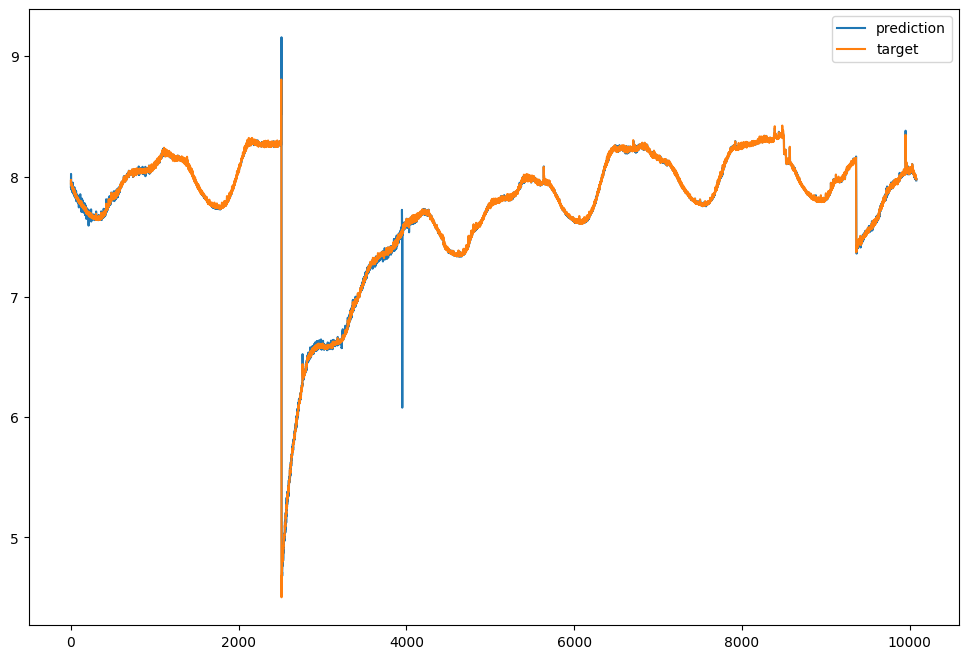

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([7.91469908, 7.93940687, 8.02177238, ..., 7.97415876, 7.98726845,
       7.96855593])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[7.941656],
       [7.972712],
       [7.94328 ],
       ...,
       [7.980072],
       [7.974312],
       [7.976136]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [31]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 0.1782222418114543 %
RMSE 0.059999268501996994
MAPE 0.1822860329411924 %


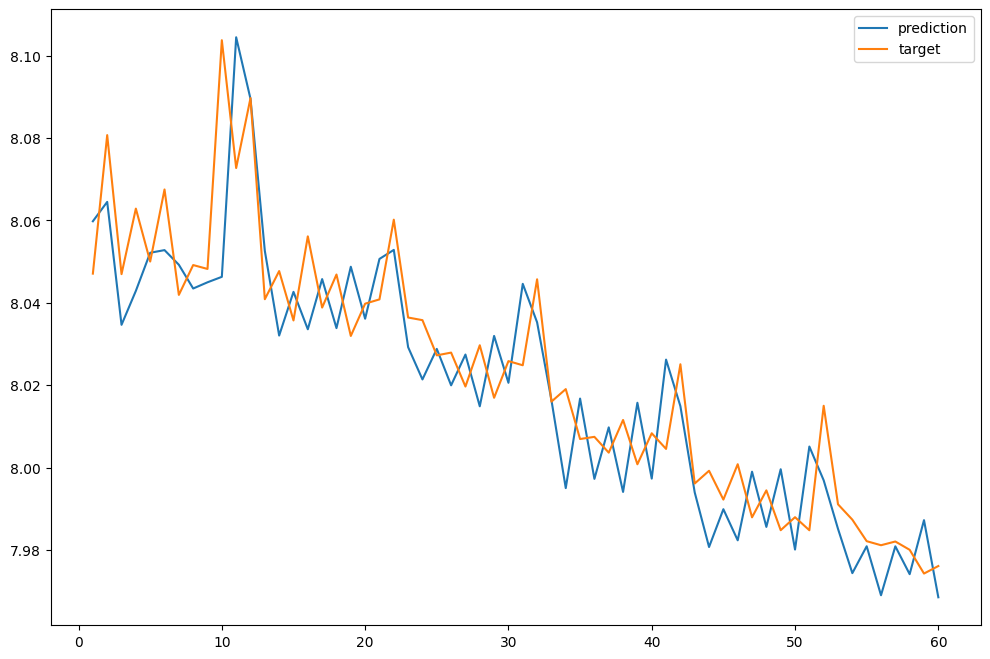

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

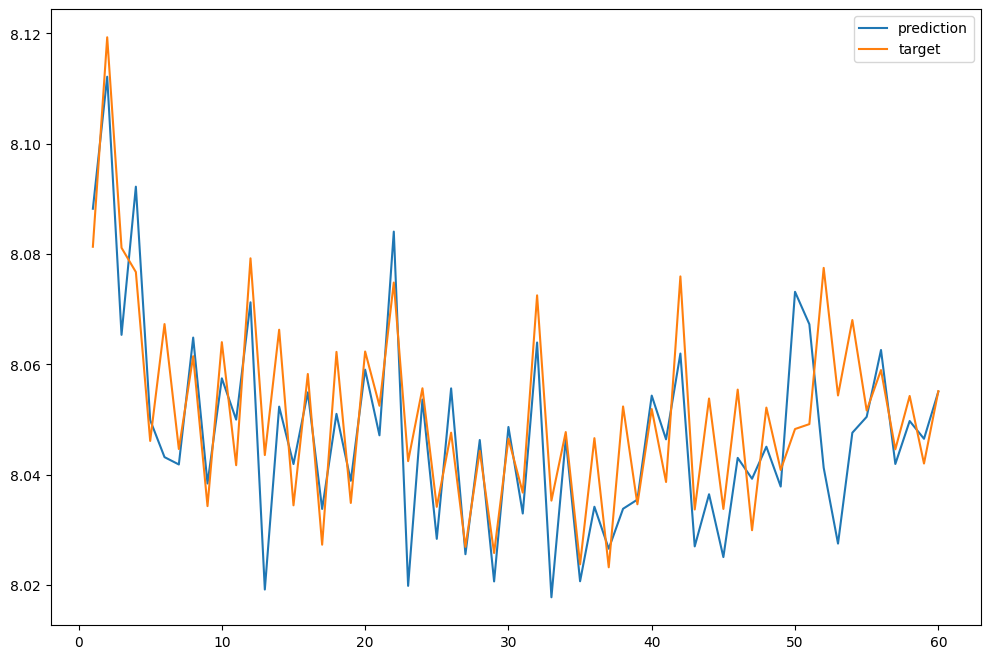

In [26]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-120:-60],label='prediction')
axes.plot(np.arange(1,61),target[-120:-60],label='target')
axes.legend()

In [27]:
len(time_list)

10080

In [28]:
np.mean(time_list) 

0.440073919012433